# Importing

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import os

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
import xgboost as xgb
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from pylab import rcParams
rcParams.update({'font.size' : 14, 'legend.fontsize' : "small", 
                 "xtick.labelsize" : 14, "ytick.labelsize" : 14, 
                 "figure.figsize":(9, 6), "axes.titlesize" : 20,
                 "axes.labelsize" : 14, "lines.linewidth" : 3, 
                 "lines.markersize" : 10
                })

/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("titanic3.csv")

# Summarizing

Significant number of values missing, I could leave this up to the algorithm like boosted trees to deal with or try to find to a reasonable measure to impute with. It is not clear what would lead to better results.

In [3]:
train.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


In [5]:
train.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [6]:
# body is an id assigned to bodies found
train.drop('body', axis = 1, inplace = True)

In [7]:
train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"


# Feature engineering

In [8]:
cabin_split = train['cabin'].str.split('(\d+)')

# function for extracting letters or numbers

def find_info(entry, number = True ):
    
        numbers = []
        
        if number is True: 
            if entry is np.nan:
                return np.nan
            else:
                for item in entry: 
                    if item.isnumeric():
                        numbers.append(float(item))
                    else:
                        numbers.append(0)
            return np.mean(numbers)
        
        else: 
            if entry is np.nan:
                return "unknown"
            for item in entry: 
                if item[0].isalpha():
                    return item
                

In [9]:
cabin_number = cabin_split.apply(find_info, number = True)
cabin_letter = cabin_split.apply(find_info, number = False)
train['cabin_letter'] = (cabin_letter)


In [10]:
check = train['home.dest'].fillna('unknown')

In [14]:
def encode_column(column):
    
    le = LabelEncoder()
    
    # le does not work with nan
    column = column.fillna('unknown')
    le.fit(column)
    column_le = le.transform(column)
    
    # replace unknown with nan
    column_le = column_le.astype('float')
    idx = [i for i, value in enumerate(column) if column[i]=='unknown']
    column_le[idx] = np.nan
    
    zip_obj = zip(list(column), column_le)
    return column_le, dict(zip_obj)        


In [15]:
train['cabin_letter_le'] = encode_column(cabin_letter)[0]
train['cabin_number'] = cabin_number
train['home_dest_le'] = encode_column(train['home.dest'])[0]

In [16]:
train['family'] = train['sibsp'] + train['parch']

In [17]:
train.isnull().sum()

pclass                0
survived              0
name                  0
sex                   0
age                 263
sibsp                 0
parch                 0
ticket                0
fare                  1
cabin              1014
embarked              2
boat                823
home.dest           564
cabin_letter          0
cabin_letter_le    1014
cabin_number       1014
home_dest_le        564
family                0
dtype: int64

# Charts

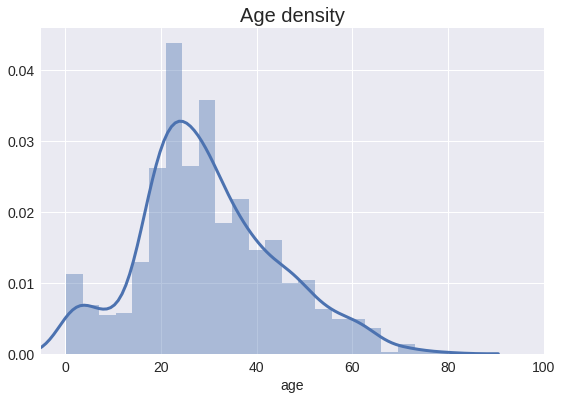

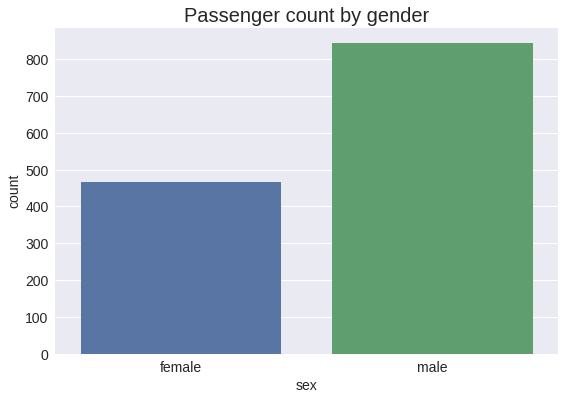

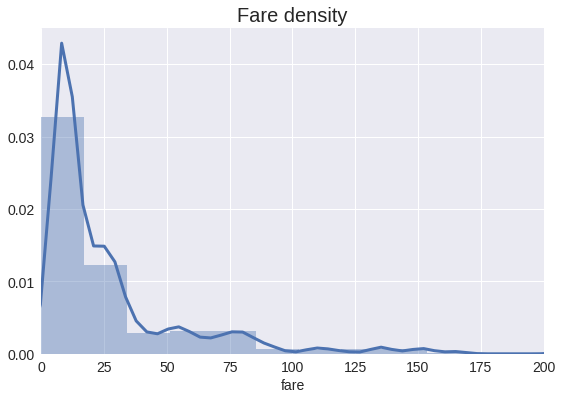

In [18]:
sns.set_style("darkgrid")

plt.title("Age density")
sns.distplot(train['age'].dropna())
plt.xlim(-5,100)
plt.show()

#fig=plt.figure(figsize=(8, 5), dpi = 150, facecolor='w', edgecolor='k')
plt.title("Passenger count by gender")
sns.countplot('sex', data = train)
plt.show()

plt.title("Fare density")
sns.distplot(train['fare'].dropna(), bins = 30)
plt.xlim(0, 200)
plt.show()

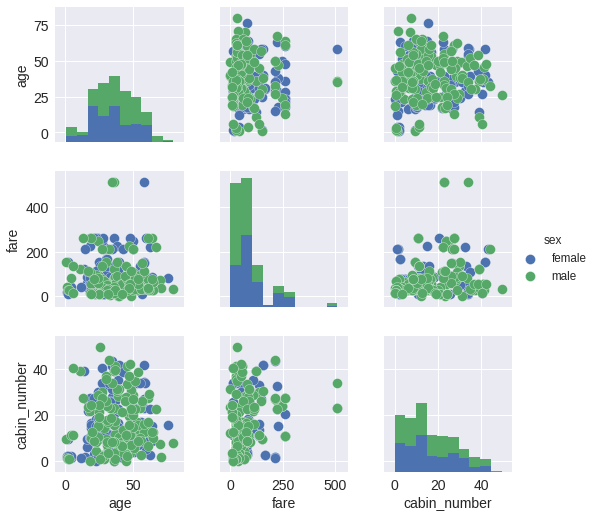

In [19]:
fig=plt.figure(figsize=(16, 16), dpi= 300)
sns.pairplot(data = train[['age', 'fare', 'cabin_number', 'sex']].dropna(), hue = 'sex')
plt.show()

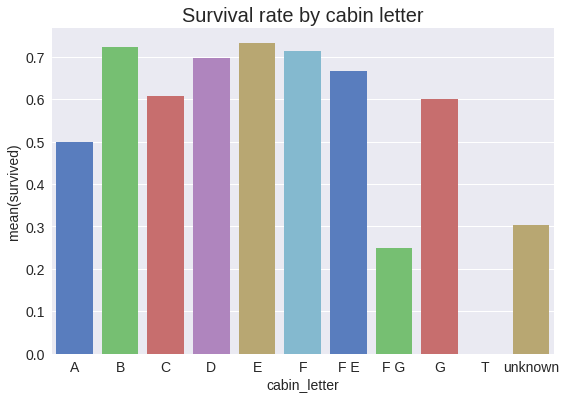

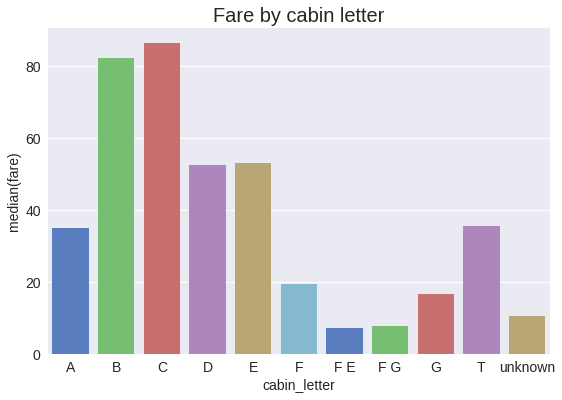

In [20]:
sns.barplot(x = "cabin_letter", y = "survived", data=train.sort_values('cabin_letter'), 
            palette = "muted", ci = None)
plt.title("Survival rate by cabin letter")
plt.show()

sns.barplot(x = "cabin_letter", y = "fare", 
            data=train[train['cabin_letter'].notnull()].sort_values('cabin_letter'), 
            palette = "muted", ci = None, estimator = np.median)
plt.title("Fare by cabin letter")
plt.show()


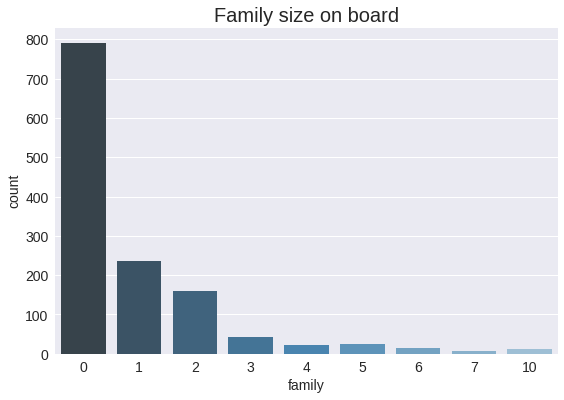

In [21]:
#fig=plt.figure(figsize=(8, 5), dpi = 150, facecolor='w', edgecolor='k')
plt.title("Family size on board")
sns.countplot(train['family'].dropna(), palette='Blues_d')
plt.show()

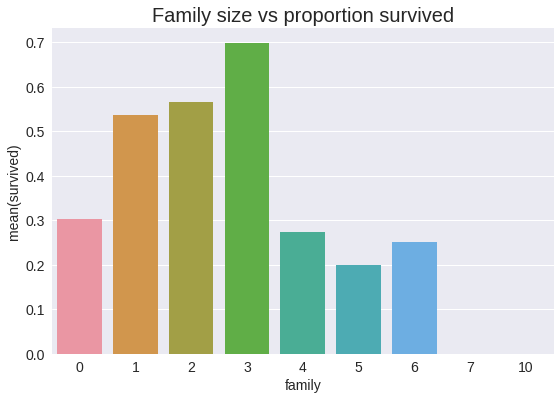

In [22]:
sns.barplot(x = "family", y = "survived", 
            data=train, 
            ci = None)
plt.title("Family size vs proportion survived")
plt.show()

## Missing data

Earlier it was evident that there were columns with a numer of values missing, it is worth considering if missing values have an impact on surviving. 

In [23]:
print(train[train['home.dest'].notnull()]['survived'].mean())
train[train['home.dest'].isnull()]['survived'].mean()

0.4657718120805369


0.2712765957446808

In [24]:
print(train['survived'][train.age.notnull()].mean())
train['survived'][train.age.isnull()].mean()

0.40822179732313574


0.27756653992395436

In [25]:
print(train[train.cabin.notnull()]['survived'].mean())
train[train.cabin.isnull()]['survived'].mean()

0.6542372881355932


0.3027613412228797

In [26]:
train[['home.dest', 'survived', 'fare']].fillna(0).groupby('home.dest').agg(
    ['mean', 'count']).sort_values([('survived', 'count')], ascending=False)[0:20]

survived              fare      
                                               mean count        mean count
home.dest                                                                  
0                                          0.271277   564   20.785668   564
New York, NY                               0.625000    64   62.976041    64
London                                     0.357143    14   20.296429    14
Montreal, PQ                               0.400000    10  117.043740    10
Cornwall / Akron, OH                       0.888889     9   20.305556     9
Paris, France                              0.888889     9   61.556011     9
Winnipeg, MB                               0.500000     8  221.448438     8
Wiltshire, England Niagara Falls, NY       0.000000     8   46.900000     8
Philadelphia, PA                           0.375000     8   28.779687     8
Brooklyn, NY                               0.714286     7   34.200014     7
Belfast                                    0.000000     7    0.000000     7
Sweden Winnipeg, MN                        0.000000     7   31.275000     7
Somerset / Bernardsville, NJ               0.600000     5   65.000000     5
Haverford, PA / Cooperstown, NY            0.800000     5  262.375000     5
Bulgaria Chicago, IL                       0.000000     5    7.815800     5
Rotherfield, Sussex, England Essex Co, MA  0.000000     5   34.375000     5
Ottawa, ON                                 0.200000     5   10.118320     5
Sweden Worcester, MA                       0.400000     5   26.669160     5
Devon, England Wichita, KS                 0.750000     4   20.575000     4
Paris / Montreal, PQ                       0.500000     4   31.514600     4

## Significance testing

In [27]:
table = np.array(pd.crosstab(train['home.dest'].isnull()*1, train['survived']))
print("p-value of chi2 independence test: {}: ".format(chi2_contingency(table, correction=True)[1]))

p-value of chi2 independence test: 1.1231092381458419e-12: 


In [28]:
table = np.array(pd.crosstab(train['age'].isnull()*1, train['survived']))
print("p-value of chi2 independence test: {}: ".format(chi2_contingency(table, correction=True)[1]))

p-value of chi2 independence test: 0.00012952163336165393: 


In [29]:
table = np.array(pd.crosstab(train['cabin'].isnull()*1, train['survived']))
print("p-value of chi2 independence test: {}: ".format(chi2_contingency(table, correction=True)[1]))

p-value of chi2 independence test: 1.649000705015759e-27: 


In [30]:
train['home_dest_null'] = train['home.dest'].isnull()*1
log_model = smf.glm('survived ~ C(home_dest_null)', 
        data = train, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1307
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -844.32
Date:                Mon, 25 Sep 2017   Deviance:                       1688.6
Time:                        20:22:23   Pearson chi2:                 1.31e+03
No. Iterations:                     4                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1371      0.073     -1.867      0.062      -0.281       0.007
C(home_dest_null)[T.1]    -0.8510      0.120     -7.101      0.000      -1.086      -0.616
==========================================================================================
"""

Looking at the means of missing data from the columns above, it seems like there is a significant difference between survival rates and if data is missing for a particular iv. Checking with logistic regression p-values and the chisq-test do suggest that have null values do indicate

# Preparing data

In [31]:
display(pd.pivot_table(train, index = ["embarked"]))
display(pd.pivot_table(train, index = ["sex"]))

,age,cabin_letter_le,cabin_number,family,fare,home_dest_le,home_dest_null,parch,pclass,sibsp,survived
embarked,,,,,,,,,,,
C,32.332170,2.000000,17.709658,0.770370,62.336267,215.784884,0.362963,0.370370,1.851852,0.400000,0.555556
Q,28.630000,3.000000,24.866667,0.455285,12.409012,136.648649,0.699187,0.113821,2.894309,0.341463,0.357724
S,29.245205,2.747059,15.920840,0.977024,27.418824,194.087850,0.414661,0.426696,2.347921,0.550328,0.332604


,age,cabin_letter_le,cabin_number,family,fare,home_dest_le,home_dest_null,parch,pclass,sibsp,survived
sex,,,,,,,,,,,
female,28.687088,2.510638,16.479230,1.285408,46.198097,200.878472,0.381974,0.633047,2.154506,0.652361,0.727468
male,30.585228,2.376623,16.985137,0.661922,26.154601,193.037199,0.457888,0.247924,2.372479,0.413998,0.190985


In [32]:
# Convert the male and female groups to integer form

train["sex"][train["sex"] == "male"] = 0
train["sex"][train["sex"] == "female"] = 1

# Impute the Embarked variable
train["embarked"] = train["embarked"].fillna("S")

# Convert the Embarked classes to integer form
train["embarked"][train["embarked"] == "S"] = 0
train["embarked"][train["embarked"] == "C"] = 1
train["embarked"][train["embarked"] == "Q"] = 2

/home/ryeyoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Rem

In [33]:
train.head(6)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,home.dest,cabin_letter,cabin_letter_le,cabin_number,home_dest_le,family,home_dest_null
0,1,1,"Allen, Miss. Elisabeth Walton",1,29.00,0,0,24160,211.3375,B5,0,2,"St Louis, MO",B,1.0,1.666667,308.0,0,0
1,1,1,"Allison, Master. Hudson Trevor",0,0.92,1,2,113781,151.5500,C22 C26,0,11,"Montreal, PQ / Chesterville, ON",C,2.0,9.600000,230.0,3,0
2,1,0,"Allison, Miss. Helen Loraine",1,2.00,1,2,113781,151.5500,C22 C26,0,NaN,"Montreal, PQ / Chesterville, ON",C,2.0,9.600000,230.0,3,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",0,30.00,1,2,113781,151.5500,C22 C26,0,NaN,"Montreal, PQ / Chesterville, ON",C,2.0,9.600000,230.0,3,0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,25.00,1,2,113781,151.5500,C22 C26,0,NaN,"Montreal, PQ / Chesterville, ON",C,2.0,9.600000,230.0,3,0
5,1,1,"Anderson, Mr. Harry",0,48.00,0,0,19952,26.5500,E12,0,3,"New York, NY",E,4.0,4.000000,236.0,0,0


In [34]:
dummy_vars = pd.get_dummies(train['pclass'], prefix = "class")
print(dummy_vars[0:6])

   class_1  class_2  class_3
0        1        0        0
1        1        0        0
2        1        0        0
3        1        0        0
4        1        0        0
5        1        0        0


In [36]:
train_processed = train.join(dummy_vars) 

Could use pclass over encoded class as different columns, under tree-based algorithms this actually works better.

In [38]:
train_processed = train_processed[train_processed.fare.notnull()]
train_processed['sex'] = train_processed['sex'].astype('int')
feature_columns_to_use =  ["age", "family", "pclass", 'sex', 'fare', 'cabin_letter_le', 'cabin_number', 'home_dest_le']


In [39]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1308
Data columns (total 22 columns):
pclass             1308 non-null int64
survived           1308 non-null int64
name               1308 non-null object
sex                1308 non-null int64
age                1045 non-null float64
sibsp              1308 non-null int64
parch              1308 non-null int64
ticket             1308 non-null object
fare               1308 non-null float64
cabin              295 non-null object
embarked           1308 non-null object
boat               486 non-null object
home.dest          745 non-null object
cabin_letter       1308 non-null object
cabin_letter_le    295 non-null float64
cabin_number       295 non-null float64
home_dest_le       745 non-null float64
family             1308 non-null int64
home_dest_null     1308 non-null int64
class_1            1308 non-null uint8
class_2            1308 non-null uint8
class_3            1308 non-null uint8
dtypes: float64(5), int6

## splitting train and test for cv

In [40]:
train_x, test_x, train_y, test_y = train_test_split(train_processed[feature_columns_to_use], 
                                                    train_processed['survived'], test_size = .3, random_state = 42)

In [41]:
print(train_x.shape)
print(test_x.shape)

(915, 8)
(393, 8)


## Imputation

From before it was established that there are significant differences between survival rates for columns with missing data, indicating that data is not missing completely at random. Since the missing data is not the cause of survival, it can be reasonably argued that the null values are missing at random and imputation could be valuable. Fancyimpute provides the MICE function to do this.

In [75]:
from fancyimpute import MICE

train_x_filled = MICE().complete(train_x.as_matrix())
test_x_filled = MICE().complete(test_x.as_matrix())

[MICE] Completing matrix with shape (915, 8)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.006
[MICE] Starting imputation round 3/110, elapsed time 0.009
[MICE] Starting imputation round 4/110, elapsed time 0.011
[MICE] Starting imputation round 5/110, elapsed time 0.013
[MICE] Starting imputation round 6/110, elapsed time 0.014
[MICE] Starting imputation round 7/110, elapsed time 0.016
[MICE] Starting imputation round 8/110, elapsed time 0.018
[MICE] Starting imputation round 9/110, elapsed time 0.020
[MICE] Starting imputation round 10/110, elapsed time 0.021
[MICE] Starting imputation round 11/110, elapsed time 0.023
[MICE] Starting imputation round 12/110, elapsed time 0.025
[MICE] Starting imputation round 13/110, elapsed time 0.027
[MICE] Starting imputation round 14/110, elapsed time 0.029
[MICE] Starting imputation round 15/110, elapsed time 0.031
[MICE] Starting imputation round 16/110, elapsed time 0.033
[MIC

# Models

## logistic

In [44]:
model = LogisticRegression()
model = model.fit(X = train_x_filled, y = train_y)
print(model.score(X = train_x_filled, y = train_y))

0.8


# random forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
#train["Sex"] = train['Sex'].astype('category')
#train["Pclass"] = train['Pclass'].astype('category')
#rf_model = RandomForestClassifier().fit(train[['Pclass', 'Sex', 'Parch', 'Fare']], train_y)
rf_model = RandomForestClassifier(n_estimators = 500, random_state=42).fit(train_x_filled, train_y)
rf_model.score(train_x_filled, train_y)

#rf_model.score(train[['Pclass', 'Sex', 'Parch', 'Fare']], train_y)

1.0

# support vector machines

In [46]:
from sklearn.svm import SVC

svm_m = SVC(kernel = "rbf", C = 100, probability = True).fit(train_x_filled, train_y)
svm_m.score(train_x_filled, train_y)

0.99890710382513659

## xgboost (gradient boosted trees)

In [47]:
model_xgb = XGBClassifier(
  learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.00,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

cvresult = xgb.cv(
                  model_xgb.get_xgb_params(), 
                  xgb.DMatrix(train_x_filled, label=train['survived'].values), 
                  num_boost_round=model_xgb.get_params()['n_estimators'], 
                  nfold=3, metrics=['auc','logloss'], 
                  early_stopping_rounds=50
                 )

#model_xgb.set_params(n_estimators=cvresult.shape[0])
    
# fit the algorithm 

model_xgb.fit(train_x_filled, train_y, eval_metric='logloss')

xgb_result1 = model_xgb.fit(train_x_filled, train_y)
xgb_result1.score(train_x_filled, train_y)

0.93442622950819676

In [62]:
cvresult.iloc[-3:-1,:]

,test-auc-mean,test-auc-std,test-logloss-mean,test-logloss-std,train-auc-mean,train-auc-std,train-logloss-mean,train-logloss-std
81,0.579509,0.007550,0.678797,0.000946,0.877880,0.010627,0.607404,0.001702
82,0.580837,0.007903,0.678626,0.001021,0.878193,0.010236,0.606569,0.001754


## Tuning xgb

In [63]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc','logloss'], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # fit the algorithm 
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='logloss')
        
    # predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # print model report
    print("\nModel Report")
    print("Accuracy : {:.4f}".format(accuracy_score(dtrain[target].values, dtrain_predictions)))
    print("AUC Score (Train): {:.4f}".format(roc_auc_score(dtrain[target], dtrain_predprob)))
    print("logloss :{:.4f}".format(log_loss(dtrain[target], dtrain_predprob)))
    
    # plotting feat_imp
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()


Model Report
Accuracy : 0.8769
AUC Score (Train): 0.9411
logloss :0.3219


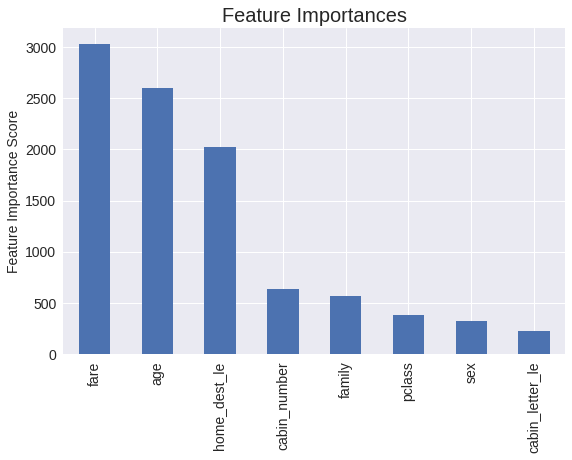

In [65]:
model_xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.00,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(model_xgb1, train_processed, feature_columns_to_use, target = 'survived')


Model Report
Accuracy : 0.8777
AUC Score (Train): 0.9416
logloss :0.3217


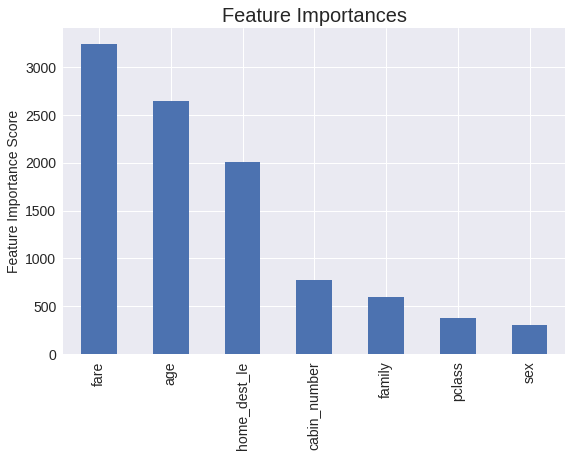

In [66]:
model_xgb1 = XGBClassifier(learning_rate =0.01, n_estimators=1000,
                             max_depth=9, min_child_weight=5,
                             gamma=0.00, subsample=0.9,
                             colsample_bytree=0.8, reg_alpha=0.05,
                             objective= 'binary:logistic', nthread=4,
                             scale_pos_weight=1, seed=27)

modelfit(model_xgb1, train_processed, ['age', 'pclass', 'family', 'sex', 'fare', 'cabin_number', 'home_dest_le'], 
         target = 'survived')

In [69]:
cv_params = {'min_child_weight':[1,2,3,4,5,6,7,8], 'max_depth':[2,3,4,5,6,7,8,9], "gamma":[0,0.001,0.1,0.5,1]}
optimized_GBM = GridSearchCV(XGBClassifier(learning_rate =0.01, n_estimators=1000,
                             max_depth=4, min_child_weight=6,
                             gamma=0.05, subsample=0.9,
                             colsample_bytree=0.8, reg_alpha=0.05,
                             objective= 'binary:logistic', nthread=4,
                             scale_pos_weight=1, seed=27), cv_params, scoring = 'neg_log_loss', cv = 5, n_jobs = 1) 

In [70]:
xgb_mod = optimized_GBM.fit(train_x[['age', 'pclass', 'family', 'sex', 'fare', 'cabin_number', 'home_dest_le']], train_y)

In [71]:
print(optimized_GBM.best_score_)
print(optimized_GBM.best_params_)

-0.430850138812
{'gamma': 0.001, 'max_depth': 3, 'min_child_weight': 1}


# Evaluation

## logistic

In [84]:

predicted = model.predict(test_x_filled)
predicted_prob = model.predict_proba(test_x_filled)

#print(metrics.confusion_matrix(train_y, predicted))
#print(train_y.astype(float).mean())
#print(predicted.astype(int).mean())

print("auc: " + str(roc_auc_score(test_y, predicted)))
print("log loss: {}".format(log_loss(test_y, predicted_prob)))
print(classification_report(test_y, predicted))

auc: 0.76556415044
log loss: 0.46980966796114154
             precision    recall  f1-score   support

          0       0.78      0.89      0.83       230
          1       0.80      0.64      0.71       163

avg / total       0.79      0.79      0.78       393



## random forest

In [78]:
predicted_rf = rf_model.predict(test_x_filled)
predicted_rf_prob = rf_model.predict_proba(test_x_filled)
print("auc:" + str(roc_auc_score(test_y, predicted_rf)))
print("log loss: {}".format(log_loss(test_y, predicted_rf_prob)))
print(classification_report(test_y, predicted_rf))

auc:0.808508935716
log loss: 0.4341980676823651
             precision    recall  f1-score   support

          0       0.82      0.89      0.85       230
          1       0.82      0.73      0.77       163

avg / total       0.82      0.82      0.82       393



## svm

In [79]:
predicted_svm = svm_m.predict(test_x_filled)
predicted_svm_prob = svm_m.predict_proba(test_x_filled)
print("auc:" + str(roc_auc_score(test_y, predicted_svm)))
print("log loss: {}".format(log_loss(test_y, predicted_svm_prob)))
print(classification_report(test_y, predicted_svm))

auc:0.516591090958
log loss: 0.6775613225392298
             precision    recall  f1-score   support

          0       0.59      0.90      0.72       230
          1       0.49      0.13      0.20       163

avg / total       0.55      0.58      0.50       393



## xgb

In [86]:
# with MICE impute
predicted_xgb = model_xgb.predict(test_x_filled)
predicted_xgb_proba = model_xgb.predict_proba(test_x_filled)
print("auc:" + str(roc_auc_score(test_y, predicted_xgb)))
print("log loss: {}".format(log_loss(test_y, predicted_xgb_proba)))
print(classification_report(test_y, predicted_xgb))

auc:0.801480394772
log loss: 0.45704047464820113
             precision    recall  f1-score   support

          0       0.81      0.89      0.85       230
          1       0.82      0.71      0.76       163

avg / total       0.82      0.82      0.81       393



In [83]:
# standard xgb impute
predicted_xgb = model_xgb1.predict(test_x[['age', 'pclass', 'family', 'sex', 'fare', 'cabin_number', 'home_dest_le']])
predicted_xgb_proba = model_xgb1.predict_proba(test_x[['age', 'pclass', 'family', 'sex', 'fare', 'cabin_number', 'home_dest_le']])
print("auc:" + str(roc_auc_score(test_y, predicted_xgb)))
print("log loss: {}".format(log_loss(test_y, predicted_xgb_proba)))
print(classification_report(test_y, predicted_xgb))

auc:0.855174713257
log loss: 0.32048847915429346
             precision    recall  f1-score   support

          0       0.85      0.94      0.89       230
          1       0.91      0.77      0.83       163

avg / total       0.87      0.87      0.87       393



Boosted trees with regularization(xgb) seems to be the best performing, while svm and rf had a high accuracy on the training set it looks like they overfit the training data. Logistic performed above expectations, plus it is easily the most interpretable algorithm.

# Digging into logistic models

## statsmodels logistic instead of sklearn

In [87]:
logit = sm.Logit(train_y.astype(float), train_x.astype(float))
# fit the model
result = logit.fit()


Optimization terminated successfully.
         Current function value: nan
         Iterations 1


In [88]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  915
Model:                          Logit   Df Residuals:                      915
Method:                           MLE   Df Model:                           -1
Date:                Mon, 25 Sep 2017   Pseudo R-squ.:                     nan
Time:                        22:17:38   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -602.11
                                        LLR p-value:                       nan
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
age                    nan        nan        nan        nan         nan         nan
family                 nan        nan        nan        nan         nan         nan
pclass                 nan        nan        nan        nan         nan         nan
sex                    nan        nan        nan        nan         nan         nan
fare                   nan        nan        nan        nan         nan         nan
cabin_letter_le        nan        nan        nan        nan         nan         nan
cabin_number           nan        nan        nan        nan         nan         nan
home_dest_le           nan        nan        nan        nan         nan         nan
===================================================================================
"""

In [89]:
log_model = smf.glm('survived ~ C(pclass) + fare + parch + C(sex)', 
        data = train, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                 1308
Model:                            GLM   Df Residuals:                     1302
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -627.75
Date:                Mon, 25 Sep 2017   Deviance:                       1255.5
Time:                        22:17:39   Pearson chi2:                 1.34e+03
No. Iterations:                     5                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5051      0.191     -2.651      0.008      -0.879      -0.132
C(pclass)[T.2]    -0.7896      0.224     -3.530      0.000      -1.228      -0.351
C(pclass)[T.3]    -1.6108      0.210     -7.658      0.000      -2.023      -1.199
C(sex)[T.1]        2.5355      0.151     16.739      0.000       2.239       2.832
fare               0.0016      0.002      0.876      0.381      -0.002       0.005
parch             -0.0886      0.084     -1.055      0.291      -0.253       0.076
==================================================================================
"""

In [90]:
log_model.params

Intercept        -0.505110
C(pclass)[T.2]   -0.789616
C(pclass)[T.3]   -1.610850
C(sex)[T.1]       2.535549
fare              0.001562
parch            -0.088585
dtype: float64

## Interpreting results


In [91]:
# men labeled 0

print("ratio for p(survive) women/men "  + str(np.exp(log_model.params[3])))
print("ratio inc/dec for each parent/child " + str(np.exp((log_model.params[5]))))

ratio for p(survive) women/men 12.6233609913
ratio inc/dec for each parent/child 0.915225138013
